In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
files = ['multiprocessing.csv', 'multiprocessing_ant.csv', 'multiprocessing_humanoid_mjx.csv',
         'mjx_newton_solver_rat.csv', 'mjx_newton_solver_ant.csv', 'mjx_newton_solver_humanoid_mjx.csv']

In [79]:
data = pd.concat([pd.read_csv(f'results/{f}') for f in files])
data.loc[data.model=='virutal_rat_mjx_version', 'model'] = 'virtual_rodent'
data.loc[data.model=='virtual_rodent_mjx_version', 'model'] = 'virtual_rodent'

In [47]:
sns.set_context("paper")

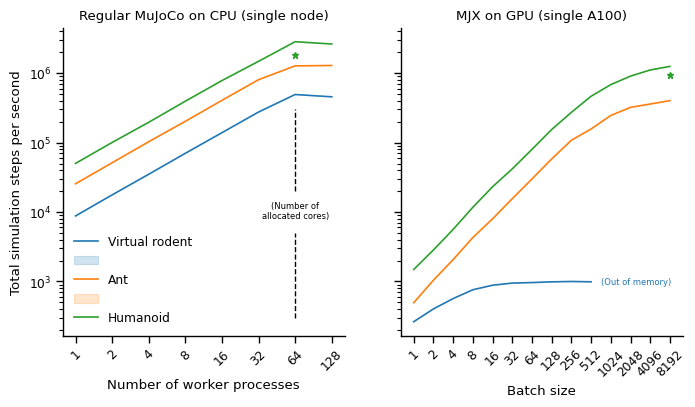

In [116]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(8, 4))
plt.sca(axs[0])
sns.lineplot(data=data.query("simulator == 'mujoco'"), x='n_workers', y='steps_per_second', hue='model', legend=False)
plt.legend(['Virtual rodent', '', 'Ant', '', 'Humanoid'], frameon=False)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of worker processes')
plt.ylabel('Total simulation steps per second')
plt.xticks(2**np.arange(8), 2**np.arange(8), rotation=45)
plt.plot([64, 64], [3e2, 5e3], ls='--', color='k', lw=1)
plt.plot([64, 64], [2e4, 3e5], ls='--', color='k', lw=1)
plt.text(64, 8e3, "(Number of\nallocated cores)", ha="center", fontsize=6)
plt.xticks([], minor=True)
plt.plot([64], [1.8e6], '*', color='C2')
plt.title("Regular MuJoCo on CPU (single node)")
sns.despine()
plt.sca(axs[1])
sns.lineplot(data=data.query("simulator == 'mjx'"), x='batch_size', y='steps_per_second', hue='model', legend=False)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Batch size')
plt.xticks(2**np.arange(15), 2**np.arange(15), rotation=45)
plt.xticks([], minor=True)
plt.plot([8192], [9.5e5], '*', color='C2')
plt.text(2**9.5, 1000, '(Out of memory)', color='C0', va='center', fontsize=6)
plt.title("MJX on GPU (single A100)")
sns.despine()
plt.savefig('plots/basic_benchmark.svg', bbox_inches='tight')

In [87]:
data.groupby(['simulator', 'model']).steps_per_second.max().to_frame().unstack()

steps_per_second                             
model                  ant  humanoid_mjx virtual_rodent
simulator                                              
mjx           4.018391e+05  1.251364e+06    1000.354898
mujoco        1.288528e+06  2.834787e+06  492427.688134

To reach 60B steps would take
 - ~16h at 10^6 steps/s
 - ~1 week at 10^5 steps/s
 - ~2 months at 10^4 steps/s
 - ~2 years at 10^3 steps/s

In [48]:
files = ['synchronized_multiprocessing_rodent_mjx_32_cores.csv', 'synchronized_multiprocessing_humanoid_mjx_32_cores.csv',
         'cython_mujoco_rodent_32_cores.csv', 'cython_mujoco_humanoid_32_cores.csv',
         'multiprocessing_humanoid_mjx_32_cores.csv', 'multiprocessing_rodent_mjx_32_cores.csv']
data = pd.concat([pd.read_csv(f'results/{f}') for f in files])
data.loc[data.parallellisation == 'synchronized_multiprocessing', 'batch_size'] = 32*data.loc[data.parallellisation == 'synchronized_multiprocessing', 'batch_per_worker']
data.loc[data.parallellisation == 'none', 'parallellisation'] = 'openMP'
#data.loc[data.parallellisation == 'none', 'parallellisation'] = 'openMP'

In [44]:
sns.set_context("paper")

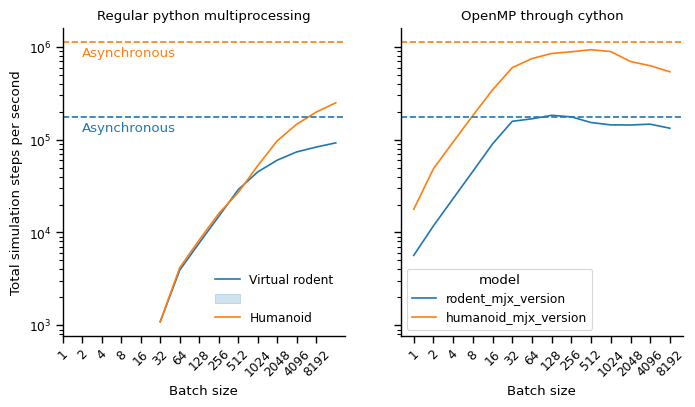

In [60]:
reference = data.query("parallellisation == 'multiprocessing' & n_workers == 32").set_index('model').steps_per_second

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(8, 4))
plt.sca(axs[0])
sns.lineplot(data=data.query("parallellisation == 'synchronized_multiprocessing'"), x='batch_size', y='steps_per_second', hue='model')
plt.legend(['Virtual rodent', '', 'Humanoid'], frameon=False)
#plt.legend(['Virtual rodent', '', 'Ant', '', 'Humanoid'], frameon=False)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Batch size')
plt.ylabel('Total simulation steps per second')
plt.xticks([], minor=True)
plt.xticks(2**np.arange(14), 2**np.arange(14), rotation=45)
plt.axhline(reference['rodent_mjx'], ls='--', color='C0')
plt.axhline(reference['humanoid_mjx'], ls='--', color='C1')
plt.text(2, reference['rodent_mjx'] * .7, "Asynchronous", color='C0')
plt.text(2, reference['humanoid_mjx'] * .7, "Asynchronous", color='C1')
plt.title('Regular python multiprocessing')
sns.despine()


plt.sca(axs[1])
sns.lineplot(data=data.query("parallellisation == 'openMP'"), x='batch_size', y='steps_per_second', hue='model')
#plt.legend(['Virtual rodent', '', 'Ant', '', 'Humanoid'], frameon=False)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Batch size')
plt.ylabel('Total simulation steps per second')
plt.xticks([], minor=True)
plt.xticks(2**np.arange(14), 2**np.arange(14), rotation=45)
plt.axhline(reference['rodent_mjx'], ls='--', color='C0')
plt.axhline(reference['humanoid_mjx'], ls='--', color='C1')
plt.title('OpenMP through cython')
sns.despine()
plt.savefig('plots/synchronous_updates.svg', bbox_inches='tight')

model
humanoid_mjx    1.137846e+06
rodent_mjx      1.747380e+05
Name: steps_per_second, dtype: float64